In [1]:
import numpy as np
from astropy.table import Table, Column
from astropy.io import fits
from astropy import units as u
import scipy.fftpack as fftpack
from scipy.stats import binned_statistic
import os
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from matplotlib.ticker import MultipleLocator
%matplotlib inline
from xcor import make_1Dlightcurve, make_binned_lc, find_nearest

# making_toy_data.ipynb
This is the notebook I use to make 'toy' (simplified) light curve data sets for use by Swapnil, the Stingray GSoC student. 

#### First, I read in the `input_file`, which is a list of data files (though actually just one for this case), and save those to an array called `data_files`. I then also read in `binning_file` which tells how I want to group the photon energies to make the light curves for the channels of interest. That information of the edges of the energy bins is stored in `chan_bins`.

In [21]:
homedir = os.path.expanduser('~')
cwd = os.getcwd()

# list_dir = homedir+'/Dropbox/Research/kHz_QPO_phase_res'
# input_file = list_dir +'/kHz_data/4U1608_eventlist_1orbit.lst'
# output_file = './toy_kHz_lightcurve.fits'
# binning_file = cwd + '/epoch1_chbinfile.txt'

# list_dir = homedir+'/Dropbox/Lists'
# input_file = list_dir +'/GX339-4HzCQPO_eventlists.lst'
# output_file = './toy_TypeC_lightcurve.fits'
# binning_file = cwd + '/epoch5_chbinfile.txt'
# object_name = "GX_339-4"

list_dir = homedir+'/Dropbox/Lists'
input_file = list_dir +'/GX339-BQPO_eventlists_9.lst'
output_file = './toy_TypeB_lightcurve.fits'
binning_file = cwd + '/epoch5_chbinfile.txt'
object_name = "GX_339-4"

debug = False

if ".txt" in input_file or ".lst" in input_file or ".dat" in input_file:
    data_files = [line.strip() for line in open(input_file)]
    if not data_files:  ## If data_files is an empty list
        raise Exception("ERROR: No files in the list of event lists.")
else:
    data_files = [input_file]
# data_files = [data_files[-1]]
data_files = [data_files[3]]

print(data_files)
binning = np.loadtxt(binning_file, dtype=np.int)
if debug:
    print("Binning from file: %s" % str(binning))
chan_bins = np.asarray([], dtype=np.int)
c = 0  # channel counter to load the binning
for grp in binning:
    if grp[2] != -1:
        for c in range(grp[0], grp[1] + 1, grp[2]):
            chan_bins = np.append(chan_bins, c)
chan_bins = np.append(chan_bins, c + binning[-2, 2])  ## End of the last bin
print(chan_bins)

['/Users/abbie/Reduced_data/GX339-BQPO/95335-01-01-01/GTId_eventlist.fits']
[ 2  4  6  9 13 28]


#### Defining the timestep (`dt`) and segment length (`n_seconds`) I want for the lightcurves. The lightcurve array then has a length of `n_bins` (the number of time bins) along axis=0.
#### We then read in an event list data file for a segment duration and 'populate' it (is the phrase I think of in my mind) to turn it from a discrete list of photon detection times to a lightcurve thats continuous in the time domain. These lightcurves have units of photon count rate (counts/second).

In [22]:
dt = 1./128.  # seconds
n_seconds = 64.  # length of light curve segment, in seconds
n_bins = int(n_seconds/dt)
print(n_bins)
detchans = 5  # len(chan_bins)-1, since chan_bins are the energy bin edges

print("dt: "+str(dt))
ref_lc = np.zeros((n_bins, 1))
ci_lc = np.zeros((n_bins, detchans, 1))
n_seg = 0

assert dt * n_bins == n_seconds
## Looping through the data files
for in_file in data_files:
    if in_file[0] == '.':
        ## Can't have relative paths
        in_file=cwd+in_file[1:]
#     if debug:
    print("Input file: "+in_file)
    ## Reading an event list from a normal FITS table
    try:
        fits_hdu = fits.open(in_file)
        time = fits_hdu[1].data.field('TIME')  ## Data is in ext 1
        channel = fits_hdu[1].data.field('CHANNEL')
        pcuid = fits_hdu[1].data.field('PCUID')
        fits_hdu.close()
    except IOError:
        print("\tERROR: File does not exist: %s" % in_file)
        break
#         exit()
    ## Using PCU=2 for the channels of interest, and PCUs=0,1,3,4 for the reference band.
    ## This lets us have simultaneous segments of the reference band and 
    ## channels of interest without "double-dipping" the photons 
    ## (which is strictly forbidden from a statistical standpoint!)
    PCU2_mask = pcuid == 2
    
    ## There's probably a more efficient way to do this, but this is what works for me for now
    ## Using masked arrays
    all_time_ci = np.asarray(time[PCU2_mask], dtype=np.float64)
    all_energy_ci = np.asarray(channel[PCU2_mask], dtype=np.float64)
    all_time_ref = np.asarray(time[~PCU2_mask], dtype=np.float64)
    all_energy_ref = np.asarray(channel[~PCU2_mask], dtype=np.float64)
    
    ## Only keeping the reference band photons in the detector energy channel range 6-35 inclusive
    ref_detchan_mask = (all_energy_ref >= 6) & (all_energy_ref <= 35)
    all_time_ref = all_time_ref[ref_detchan_mask]
    
    ## Determining start and stop times for segments, to avoid large time gaps in the middle of segments 
    ## (those are bad! they'll give weird artefacts in the Fourier domain)
    ci_start_time = all_time_ci[0]
    ci_final_time = all_time_ci[-1]
    ref_start_time = all_time_ref[0]
    ref_final_time = all_time_ref[-1]
    if ci_start_time > ref_start_time:
        index = np.min(np.where(all_time_ref > ci_start_time))
        start_time = all_time_ref[index]
        all_time_ref = all_time_ref[index:]
    else:
        start_time = ref_start_time
    final_time = np.min([ref_final_time, ci_final_time])
    seg_end_time = start_time + n_seconds
    
    ########################################################
    ## Looping through the data event list to make segments
    ########################################################
    while seg_end_time <= final_time:

        ## Get events for channels of interest
        time_ci = all_time_ci[np.where(all_time_ci < seg_end_time)]
        energy_ci = all_energy_ci[np.where(all_time_ci < seg_end_time)]

        ## Chop current segment off the rest of the list
        for_next_iteration_ci = np.where(all_time_ci >= seg_end_time)
        all_time_ci = all_time_ci[for_next_iteration_ci]
        all_energy_ci = all_energy_ci[for_next_iteration_ci]

        ## Get events for reference band
        time_ref = all_time_ref[np.where(all_time_ref < seg_end_time)]

        ## Chop current segment off the rest of the list so we don't drag it around
        for_next_iteration_ref = np.where(all_time_ref >= seg_end_time)
        all_time_ref = all_time_ref[for_next_iteration_ref]

        if debug:
            print("Len time ci:"+str(len(time_ci)))
            print("Len time ref:"+str(len(time_ref)))

        ## At the end of a segment, check that there are events in it
        if len(time_ci) > 0 and len(time_ref) > 0:
            ## I think of this step as 'populating' the light curve from the event list.
            ## It takes a discrete list of the event times and turns it into a continuous lightcurve
            lc_ci_seg = make_binned_lc(np.asarray(time_ci), np.asarray(energy_ci), 
                                           n_bins, chan_bins, start_time, seg_end_time)
            lc_ref_seg = make_1Dlightcurve(np.asarray(time_ref), n_bins, start_time, seg_end_time)

            if debug:
                print("Shape ref lc:" + str(np.shape(lc_ref_seg)))
                
            ## Putting the segment on the lightcurve
            ref_lc = np.concatenate((ref_lc, lc_ref_seg[:,np.newaxis]), axis=1)
            ci_lc = np.concatenate((ci_lc, lc_ci_seg[:,:,np.newaxis]), axis=2)
            start_time = seg_end_time
            seg_end_time += n_seconds
            n_seg += 1
            if n_seg % 10 == 0:
                print("\t%d"% n_seg)
            if n_seg >= 10 and debug:
                break
#             if n_seg >= 20:
#                 break
        ## This 'else' deals with data that has some time gaps in the event list
        else:
            start_time = np.max([all_time_ci[0], all_time_ref[0]])
            seg_end_time = start_time + n_seconds
            
## Cut off the zeros I used to initialize the lightcurves
ref_lc = ref_lc[:,1:]
ci_lc = ci_lc[:,:,1:]
## Checking that I cut off on the correct axis
print("Shape of ref lc: "+str(np.shape(ref_lc)))
print("Shape of ci lc: "+str(np.shape(ci_lc)))

8192
dt: 0.0078125
Input file: /Users/abbie/Reduced_data/GX339-BQPO/95335-01-01-01/GTId_eventlist.fits
	10
	20
	30
	40
Shape of ref lc: (8192, 46)
Shape of ci lc: (8192, 5, 46)


Ignore the astropy.io.fits warning. The FITS header keyword doesn't update after I do the filtering for "Good Times Intervals" (to cut out flaring or when the telescope wasn't pointed correctly) in a previous step elsewhere.
#### Taking a look at the mean count rate in each energy channel per segment. I did this to check that I was using good energy ranges for the channels of interest, so that they had roughly similar count rates.

In [23]:
ci_means = np.mean(ci_lc, axis=0)  ## Averaging for each segment in each channel of interest
ci_means = np.mean(ci_means, axis=-1) ## Averaging across segments in each channel of interest
print(ci_means)
## Checking that the means have a shape equal to the number of channels of interest
print(np.shape(ci_means))
ref_means = np.mean(ref_lc)
print(ref_means)

[214.2890625  187.34578804 154.50271739 101.62330163  88.04517663]
(5,)
456.93682065217394


#### Saving these lightcurves to an astropy table

In [19]:
lightcurves = Table()
lightcurves.add_column(Column(name='REF', data=ref_lc, unit=u.ct/u.s,
                              description="Reference band light curves"))
lightcurves.add_column(Column(name='CI', data=ci_lc, unit=u.ct/u.s,
                              description="Channels of interest light curves"))
lightcurves.meta['N_BINS'] = n_bins
lightcurves.meta['DT'] = dt
lightcurves.meta['DETCHANS'] = detchans
lightcurves.meta['CHBIN'] = str(binning_file)
lightcurves.meta['N_SEG'] = n_seg
lightcurves.meta['NSECONDS'] = n_seconds
lightcurves.meta['INFILE'] = str(data_files)
lightcurves.meta['OBJECT'] = object_name

print(lightcurves.info)
print(lightcurves.meta)

<Table length=8192>
name  dtype   shape    unit             description           
---- ------- -------- ------ ---------------------------------
 REF float64   (213,) ct / s       Reference band light curves
  CI float64 (5, 213) ct / s Channels of interest light curves

OrderedDict([('N_BINS', 8192), ('DT', 0.0078125), ('DETCHANS', 5), ('CHBIN', '/Users/abbie/Documents/GitHub/gsoc18/epoch5_chbinfile.txt'), ('N_SEG', 213), ('NSECONDS', 64.0), ('INFILE', "['/Users/abbie/Reduced_data/GX339-BQPO/95335-01-01-05/GTId_eventlist.fits', '/Users/abbie/Reduced_data/GX339-BQPO/95335-01-01-07/GTId_eventlist.fits', '/Users/abbie/Reduced_data/GX339-BQPO/95335-01-01-00/GTId_eventlist.fits', '/Users/abbie/Reduced_data/GX339-BQPO/95335-01-01-01/GTId_eventlist.fits', '/Users/abbie/Reduced_data/GX339-BQPO/95409-01-18-00/GTId_eventlist.fits', '/Users/abbie/Reduced_data/GX339-BQPO/95409-01-17-05/GTId_eventlist.fits', '/Users/abbie/Reduced_data/GX339-BQPO/95409-01-18-05/GTId_eventlist.fits', '/Users/abbie/

#### Writing the astropy table

In [11]:
lightcurves.write(output_file, format='fits', overwrite=True)

## And that's what was done for making the toy data set! 
### Below here, I'm playing with it (not using Stingray) to check that we can see the QPO and can average it across segments and linearly re-bin the averaged ps in frequency.

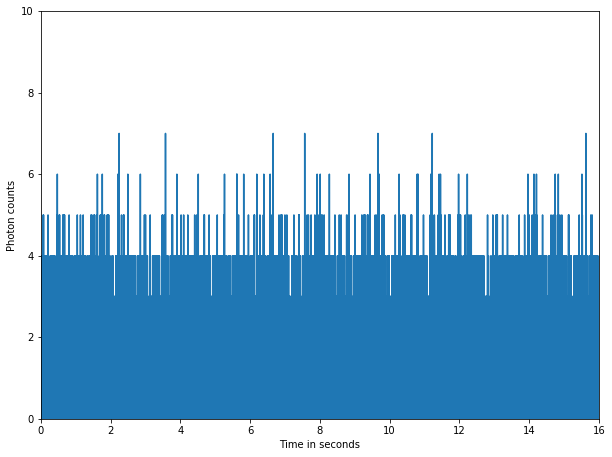

In [24]:
## Plotting one segment of the reference band light curve:
time = np.arange(n_bins)*dt # in seconds
counts_ref_lc = lightcurves['REF'][:,1] * dt # the 2nd segment of the ref band light curve, *dt so its in counts 
fig, ax = plt.subplots(1, 1, figsize=(10, 7.5))
ax.plot(time, counts_ref_lc)
ax.set_xlabel("Time in seconds")
ax.set_ylabel("Photon counts")
ax.set_xlim(0,16)
ax.set_ylim(0,10)
plt.show()

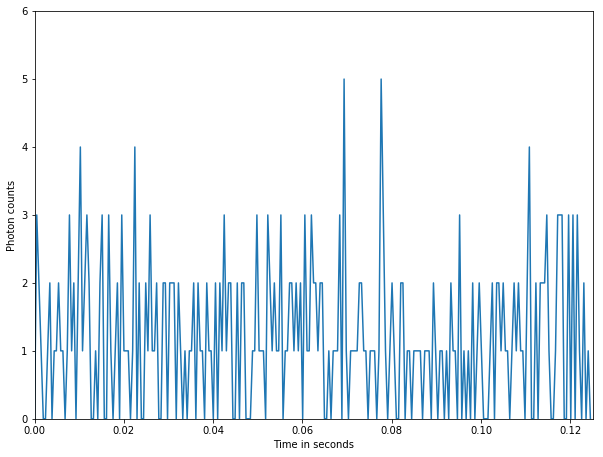

In [25]:
## Plotting just the first 256 time bins of the 2nd segment
fig, ax = plt.subplots(1, 1, figsize=(10, 7.5))
ax.plot(time[0:256], counts_ref_lc[0:256])
ax.set_xlabel("Time in seconds")
ax.set_ylabel("Photon counts")
ax.set_xlim(0,0.125)
ax.set_ylim(0,6)
plt.show()

In [26]:
class QPO(object):
    """
    Generic QPO class for energy-resolved CCF.
    """
    def __init__(self, lightcurves, dt, debug=False):
        assert isinstance(debug, bool), "`debug` should be a boolean."
        self.debug = debug
        if self.debug:
            print("QPO init")
        ## Check the inputs
        assert isinstance(dt, float), "`dt` should be a float."
        if self.debug:
            print("* Get basic info from input light curves")
        self.dt = dt
        if self.debug:
            print("dt in QPO init: " + str(self.dt))
        self.n_bins = lightcurves.meta['N_BINS']
        self.detchans = lightcurves.meta['DETCHANS']
        self.n_seg = lightcurves.meta['N_SEG']
        if self.debug:
            print("* Compute Fourier frequencies and `df`")
        self.n_seconds = self.n_bins * self.dt
        self.freq = fftpack.fftfreq(self.n_bins, d=self.dt)
        ## Only the positive Fourier frequencies:
        self.pfreq = np.abs(self.freq[0:int(self.n_bins/2)+1])
        ## DF, delta frequency, gives the lowest possible frequency in Fourier space (and also the frequency resolution):
        self.df = 1. / (self.n_seconds)
        ## The Nyquist frequency is the highest possible positive Fourier frequency it'll reach:
        self.nyquist = 1. / (2. * self.dt)
        ## The total length of the lightcurve used ('exposure time' of the observation):
        self.exposure = self.n_bins * self.dt * self.n_seg
        assert np.median(np.diff(self.freq)) == self.df, "Diff in `self.freq` doesn't match `df`."
        if self.debug:
            print("n seconds in QPO init: "+ str(self.n_seconds))
            print("df in QPO init: " + str(self.df))
            print("Nyquist in QPO init: " + str(self.nyquist))  
            print("Exposure in QPO init: " + str(self.exposure))
        if self.debug:
            print("* Compute FFTs")
        self.fft_ref, self.mean_rate_ref = self._fft(lightcurves['REF'])
        self.fft_ci, self.mean_rate_ci = self._fft(lightcurves['CI'])
        if self.debug:
            print("* Compute power spectra")
        self.psd_ref = self._cross(self.fft_ref, self.fft_ref).real
        assert np.shape(self.psd_ref) == np.shape(self.fft_ref), "Ref power spectrum has"\
               "wrong array shape."
        self.psd_ci = self._cross(self.fft_ci, self.fft_ci).real
        assert np.shape(self.psd_ci) == np.shape(self.fft_ci), "CI power spectrum has "\
               "wrong array shape."
        assert np.isfinite(self.psd_ref).all(), "Unfiltered PSD of ref has infinite value(s)."
        assert np.isfinite(self.psd_ci).all(), "Unfiltered PSD of ci has infinite value(s)."
        assert not np.isnan(self.psd_ref).all(), "Unfiltered PSD of ref has NaN value(s)."
        assert not np.isnan(self.psd_ci).all(), "Unfiltered PSD of ci has NaN value(s)."
        
        ## Taking the average across the segments
        self.avgpsd_ref = np.mean(self.psd_ref, axis=-1)
        self.avgpsd_ci = np.mean(self.psd_ci, axis=-1)

    def _fft(self, lc):
        """
        Subtract the mean from a light curve and take the Fourier transform of
        the mean-subtracted light curve. Assumes that the time bins are along
        axis=0.
        """
        if self.debug:
            print("FFT")
        means = np.mean(lc, axis=0)
        print("Shape means:" +str(np.shape(means)))
        if len(np.shape(lc)) == 2 or len(np.shape(lc)) == 3:
            lc_sub_mean = lc - means[np.newaxis, :]
        elif len(np.shape(lc)) == 1:
            lc_sub_mean = lc - means
        else:
            print(
            "WARNING: Light curve array does not have expected dimensions. " \
            "Do not assume the mean count rate was subtracted correctly " \
            "before FFT.")
            lc_sub_mean = lc - means
        return fftpack.fft(lc_sub_mean, axis=0), means

    def _cross(self, fft_1, fft_2):
        """
        Take the cross spectrum of two Fourier transforms.
        Behaves as a power spectrum if you give the same FFT twice.
        """
        if self.debug:
            print("Cross")
        if np.shape(fft_1) == np.shape(fft_2):  # if it's a power spectrum
            if self.debug:
                print("Just kidding, we're making a power spectrum.")
                print("Shape 1: "+str(np.shape(fft_1)))
                print("Shape 2: "+str(np.shape(fft_2)))
            return np.multiply(fft_1, np.conj(fft_2))
        return np.multiply(fft_1, np.conj(fft_2[:, np.newaxis, :]))

    def _pow_err(self, psd):
        """
        Compute the error on the power (assuming you have more than 50 segments
        averaged together).
        """
        if self.debug:
            print("Pow err")
        if self.n_seg < 50:
            print("WARNING: Not enough segments to assume Gaussian errors on the "\
                  "averaged power spectrum. See Uttley et al. 2014 (X-ray reverb "\
                  "review) p 9 footnote 3 for details and references.")
        return psd / np.sqrt(self.n_seg)


In [27]:
khzqpo = QPO(lightcurves, dt, debug=False)
print(khzqpo.df)
print(np.shape(khzqpo.avgpsd_ref))
print(np.shape(khzqpo.avgpsd_ci))
## Applying 'absolute rms^2 normalization' to the power spectrum
khzqpo.avgpsd_ref *= 2.* dt / float(n_bins)
khzqpo.avgpsd_ci *= 2.* dt / float(n_bins)

Shape means:(20,)
Shape means:(5, 20)
0.0625
(32768,)
(32768, 5)


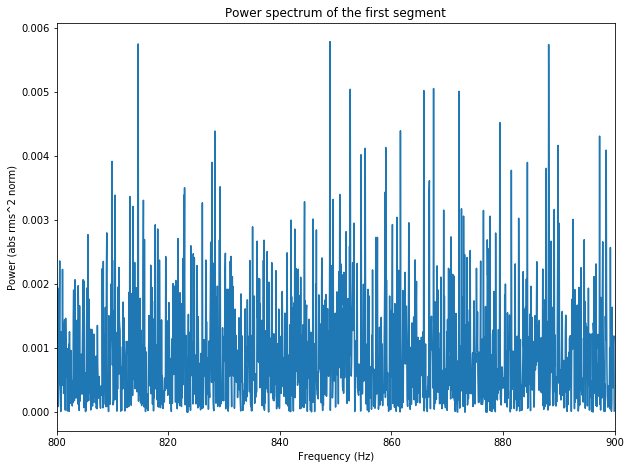

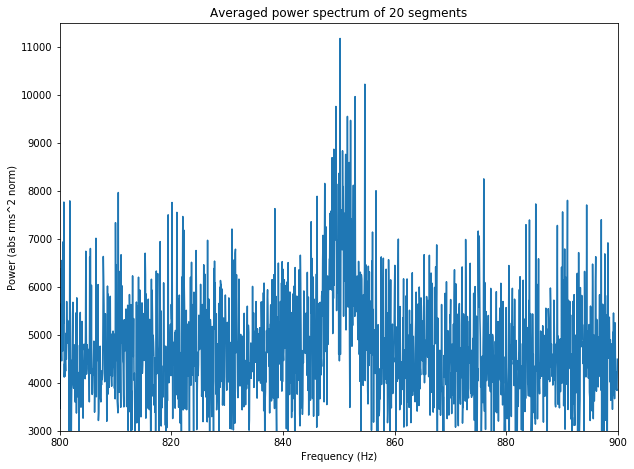

In [44]:
lf = int(find_nearest(khzqpo.pfreq, 800)[1])
uf = int(find_nearest(khzqpo.pfreq, 900)[1])
fig, ax = plt.subplots(1, 1, figsize=(10, 7.5))
ax.plot(khzqpo.pfreq[lf:uf], khzqpo.psd_ref[lf:uf,0]*(2.*dt/float(n_bins)/khzqpo.mean_rate_ref[0]**2))
ax.set_xlim(khzqpo.pfreq[lf], khzqpo.pfreq[uf])
# ax.set_ylim(0,30500)
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Power (abs rms^2 norm)")
ax.set_title("Power spectrum of the first segment")
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 7.5))
ax.plot(khzqpo.pfreq[lf:uf], khzqpo.avgpsd_ref[lf:uf])
ax.set_xlim(khzqpo.pfreq[lf], khzqpo.pfreq[uf])
ax.set_ylim(3000,11500)
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Power (abs rms^2 norm)")
ax.set_title("Averaged power spectrum of 20 segments")
plt.show()

#### Linearly re-binning the averaged power spectrum helps to reduce the noisiness and make the QPO peak stand out more.

In [39]:
p_freq = khzqpo.pfreq
print("Old df: %.4f Hz" % (p_freq[1]-p_freq[0]))
lin_psd, f_bin_edges, something = binned_statistic(p_freq, khzqpo.avgpsd_ref[0:int(khzqpo.n_bins/2+1)], 
                            statistic='mean', bins=1600)
new_df = np.median(np.diff(f_bin_edges))
print("New df: %.2f Hz" % new_df)
lin_pfreq = f_bin_edges[0:-1]+0.5*new_df  # so that the frequency is mid-bin

Old df: 0.0625 Hz
New df: 0.64 Hz


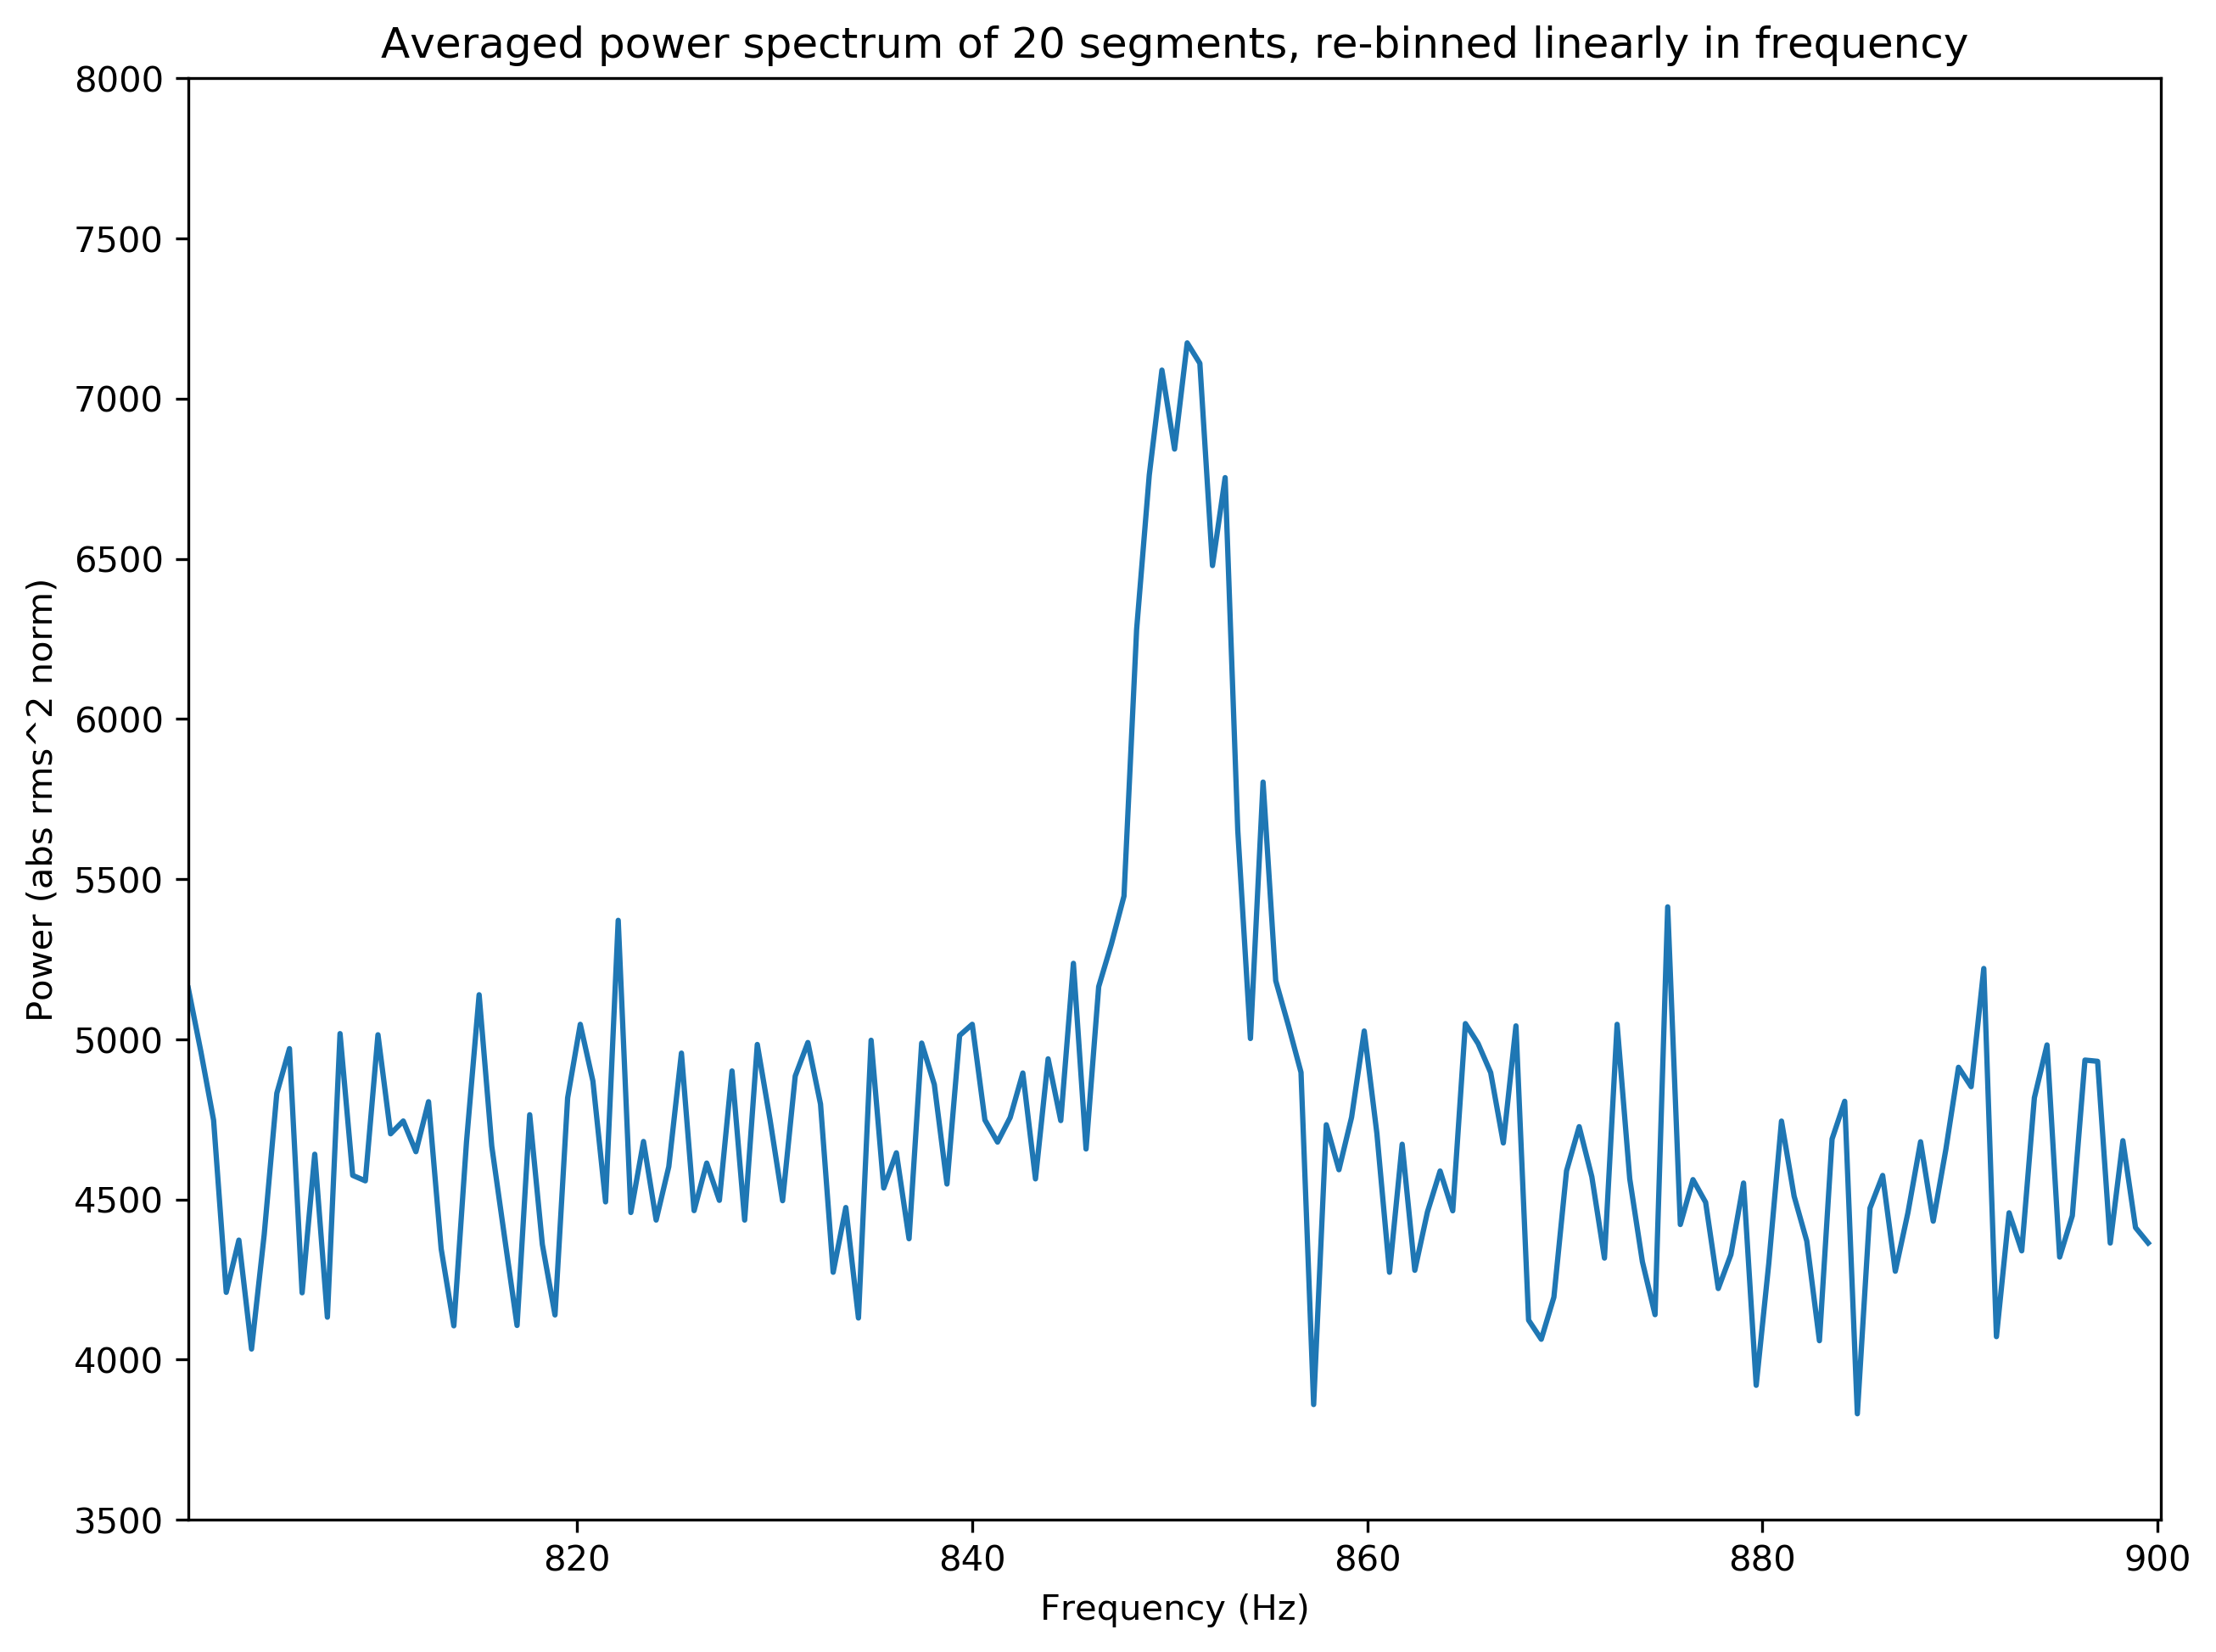

In [40]:
lf = int(find_nearest(lin_pfreq, 800)[1])
uf = int(find_nearest(lin_pfreq, 900)[1])

font_prop = font_manager.FontProperties(size=20)
fig, ax = plt.subplots(1, 1, figsize=(10, 7.5), dpi=300)
ax.plot(lin_pfreq[lf:uf], lin_psd[lf:uf])
ax.set_xlim(lin_pfreq[lf], lin_pfreq[uf])
ax.set_ylim(3500,8000)
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Power (abs rms^2 norm)")
ax.set_title("Averaged power spectrum of 20 segments, re-binned linearly in frequency")
plt.show()

# What a beautiful QPO peak!